imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.config import INTERIM_DIR, SENTINEL_DIR
from src.geo.tiling import extract_tiles_from_cube


Load Mask and Tile coordinates

In [2]:
coords = np.load(INTERIM_DIR / "tile_coords.npy")
print("Loaded tile coords:", coords.shape)


Loaded tile coords: (109, 2)


load two sentinel years 

In [3]:
cube_2019 = np.load(SENTINEL_DIR / "s2_ne_2019.npy")
cube_2024 = np.load(SENTINEL_DIR / "s2_ne_2024.npy")


extract matching tiles

In [4]:
tiles_2019 = extract_tiles_from_cube(cube_2019, coords, tile_size=32)
tiles_2024 = extract_tiles_from_cube(cube_2024, coords, tile_size=32)


plot same tile across time

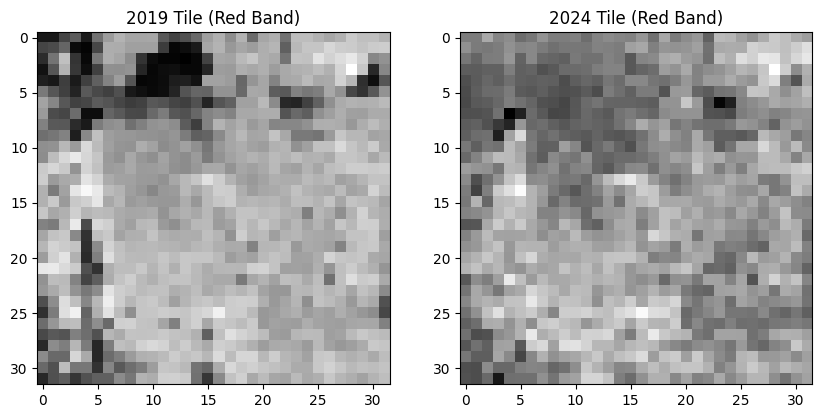

In [5]:
idx = np.random.randint(0, len(coords))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(tiles_2019[idx][..., 3], cmap="gray")  # red band
ax[0].set_title("2019 Tile (Red Band)")

ax[1].imshow(tiles_2024[idx][..., 3], cmap="gray")
ax[1].set_title("2024 Tile (Red Band)")

plt.show()
